# Introduction to artificial neural networks and autoencoders

Harry Scholes

17 August, 2018

In [1]:
from keras import backend as K
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
K.tensorflow_backend.set_session(K.tf.Session(config=config))

/Users/harry/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Conv2D, Reshape, Dropout, Flatten, MaxPool2D, UpSampling2D, Reshape
from sklearn.metrics import accuracy_score, precision_recall_curve, auc
import graphviz
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from numba import jit
%matplotlib inline

In [3]:
def show_image(x, ax=None):
    if ax is not None:
        ax.imshow(x.reshape(28, 28), cmap='Greys_r')
    plt.imshow(x.reshape(28, 28), cmap='Greys_r')

def show_images(X, y_true, y_pred=None):
    indexes = np.random.choice(range(X.shape[0]), 25)
    X = X[indexes]
    y_true = y_true[indexes]
    if y_pred is not None:
        y_pred = y_pred[indexes]
    fig, axes = plt.subplots(5, 5, figsize=(5,5))
    axes = axes.flatten()
    for idx, ax in enumerate(axes):
        show_image(X[idx], ax)
        ax.set_title(f'{y_true[idx]} {f", {y_pred[idx]}" if y_pred is not None else ""}')
        ax.axis('off')
    fig.tight_layout(h_pad=-1, w_pad=-1)

def show_decodings(X, Z):
    indexes = np.random.choice(range(X.shape[0]), 10)
    X = X[indexes]
    Z = Z[indexes]
    fig, axes = plt.subplots(5, 4, figsize=(5, 5))
    axes = axes.flatten()
    for idx, (ax, i) in enumerate(zip(axes, np.repeat(np.arange(X.shape[0]), 2))):
        if idx % 2 == 0:
            show_image(X[i], ax)
        else:
            show_image(Z[i], ax)
        ax.axis('off')
    
    for ax, label in zip(axes[:4], ['Original', 'Decoded', 'Original', 'Decoded']):
        ax.set_title(label)
    fig.tight_layout(h_pad=-1, w_pad=-1)

def load_mnist_vectors():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(-1, 28**2) / 255
    x_test = x_test.reshape(-1, 28**2) / 255
    return x_train, y_train, x_test, y_test

def load_mnist_images():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(-1, 28, 28, 1) / 255
    x_test = x_test.reshape(-1, 28, 28, 1) / 255
    return x_train, y_train, x_test, y_test

def stack_x(X):
    s = X.shape[0]
    return np.hstack((X[:s//2], X[s//2:]))

def stack_y(Y):
    s = Y.shape[0]
    return coo_matrix((np.ones(s), (np.tile(np.arange(s//2), 2), Y))).toarray()

@jit
def corrupt_image(im):
    x_start = np.random.randint(4, 20)
    y_start = np.random.randint(4, 20)
    xs = np.arange(x_start, x_start + np.random.randint(6, 10))
    ys = np.arange(y_start, y_start + np.random.randint(6, 10))
    
    square = np.zeros_like(im)
    
    for i in xs:
        for j in ys:
            square[i, j] += 1

    return np.clip(im + square, 0, 1)


NN_schematic = graphviz.Digraph()
NN_schematic.edge('Input (784D)', 'Hidden (128 neurons)')
NN_schematic.edge('Hidden (128 neurons)', 'Output (10 classes)')
NN_schematic.graph_attr['rankdir'] = 'LR'

AE_diagram = graphviz.Digraph()
AE_diagram.edge('Input (784D)', 'Hidden (128 neurons)')
AE_diagram.edge('Hidden (128 neurons)', 'Output (784D)')
AE_diagram.graph_attr['rankdir'] = 'LR'

DAE_diagram = graphviz.Digraph()
DAE_diagram.edge('784D', '256')
DAE_diagram.edge('256', '128')
DAE_diagram.edge('128', '2')
DAE_diagram.edge('2', '128 ')
DAE_diagram.edge('128 ', '256 ')
DAE_diagram.edge('256 ', '784D ')
DAE_diagram.graph_attr['rankdir'] = 'LR'

cmap = sns.husl_palette(10)

In [4]:
# Globals
epochs = 2

# Introduction to artificial neural networks and autoencoders

## Machine learning essentials

* In supervised ML, classifiers learn mappings of **features** to **labels**
* Models are **trained** on the **training data**
* Performance is measured on the **test data**
* Training and test data should be **disjoint**

* It's just fancy regression 😈

## Neural networks key concepts

### Architecture

* Layers
* Neurons (units)
* Activation functions

### Learning

* Loss function
* Optimizer
* Epochs

### Tools

* TensorFlow
* Keras

# Hello, world!

Train a feed-forward neural network with one hidden layer

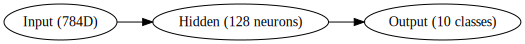

In [5]:
NN_schematic

### Load MNIST data set of handwritten digits

* 28 x 28 pixel images
* 60,000 training examples
* 10,000 testing examples

In [6]:
x_train, y_train, x_test, y_test = load_mnist_vectors()

x_train.shape

(60000, 784)

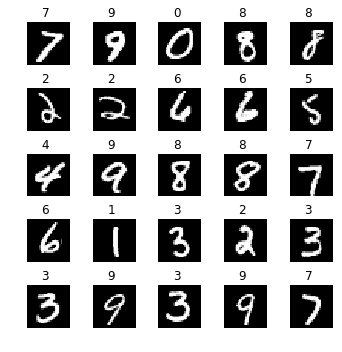

In [7]:
show_images(x_train, y_train)

Define the network architecture

In [8]:
inputs = Input(shape=(x_train.shape[1],))
hidden = Dense(units=128, activation='relu')(inputs)
outputs = Dense(units=10, activation='softmax')(hidden)

model = Model(inputs, outputs)

Compile and train

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_split=.2, epochs=epochs)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 4s 87us/step - loss: 0.2903 - acc: 0.9180 - val_loss: 0.1593 - val_acc: 0.9547
Epoch 2/2
48000/48000 [==============================] - 4s 79us/step - loss: 0.1275 - acc: 0.9623 - val_loss: 0.1207 - val_acc: 0.9638


Predict labels

In [10]:
y_proba = model.predict(x_test)
y_pred = y_proba.argmax(axis=1)

Anatomy of a prediction

In [11]:
y_proba[0]

array([5.2013402e-06, 5.7320086e-08, 3.8681031e-04, 1.3719680e-03,
       1.8474507e-08, 8.5386370e-07, 2.4391769e-10, 9.9817371e-01,
       3.8130650e-06, 5.7443962e-05], dtype=float32)

In [12]:
y_pred[0]

7

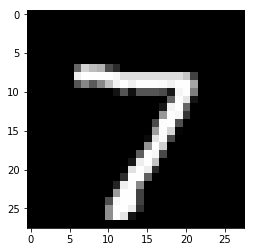

In [13]:
show_image(x_test[0])

Performance metrics

In [14]:
accuracy_score(y_test, y_pred)

0.9655

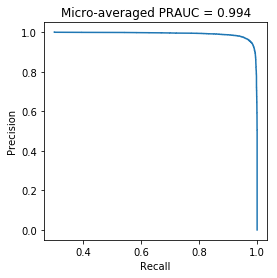

In [15]:
p, r, _ = precision_recall_curve(to_categorical(y_test).flatten(), y_proba.flatten())

plt.figure(figsize=(4,4)); plt.plot(p, r); plt.ylabel('Precision'); plt.xlabel('Recall')
plt.title(f'Micro-averaged PRAUC = {auc(r, p):.3f}');

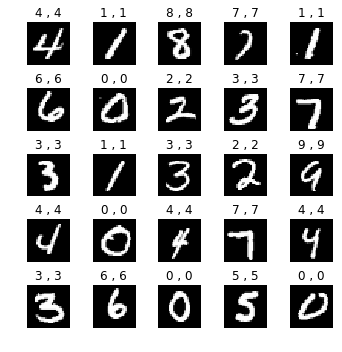

In [16]:
correct = np.where(y_pred == y_test)
show_images(x_test[correct], y_test[correct], y_pred[correct])

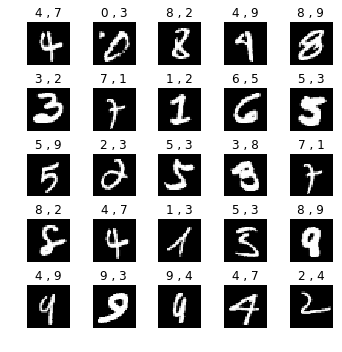

In [17]:
wrong = np.where(y_pred != y_test)
show_images(x_test[wrong], y_test[wrong], y_pred[wrong])

# Convolutional neural networks

* Class of feed-forward neural network used to process **grid-like data**
* The **input** is scanned by multiple **filters** (or **kernels**) to produce a **feature map**
* This allows the network to detect **space-invariant properties**

![CNN](img/CNN.png)

In [18]:
x_train, y_train, x_test, y_test = load_mnist_images()

In [19]:
inputs = Input(shape=x_train.shape[1:])

conv = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
pooling = MaxPool2D()(conv)
dropout = Dropout(0.5)(pooling)

conv = Conv2D(64, kernel_size=(3, 3), activation='relu')(dropout)
pooling = MaxPool2D()(conv)
dropout = Dropout(0.5)(pooling)

flatten = Flatten()(dropout)

hidden = Dense(128, activation='relu')(flatten)
outputs = Dense(10, activation='softmax')(hidden)

model = Model(inputs, outputs)

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)          0         
__________

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, validation_split=.2, epochs=epochs)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 54s 1ms/step - loss: 0.2590 - acc: 0.9188 - val_loss: 0.0728 - val_acc: 0.9795
Epoch 2/2
48000/48000 [==============================] - 52s 1ms/step - loss: 0.1014 - acc: 0.9681 - val_loss: 0.0516 - val_acc: 0.9847


In [22]:
y_proba = model.predict(x_test)
y_pred = y_proba.argmax(1)

accuracy_score(y_test, y_pred)

0.9874

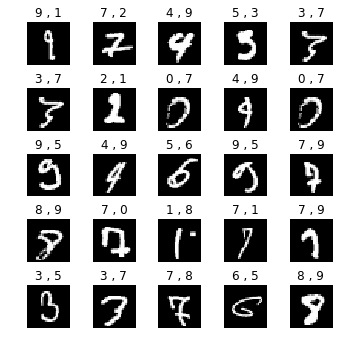

In [23]:
wrong = np.where(y_pred != y_test)
show_images(x_test[wrong], y_test[wrong], y_pred[wrong])

## Stacking

Stack two digits on top of each other and predict both labels simultaneously

In [24]:
x_train, y_train, x_test, y_test = load_mnist_images()

x_train, x_test = stack_x(x_train), stack_x(x_test)
y_train, y_test = stack_y(y_train), stack_y(y_test)

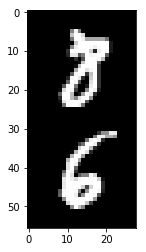

In [25]:
plt.imshow(x_train.squeeze()[np.random.randint(0, x_train.shape[0])], cmap='Greys_r');

Train a neural network with one hidden layer

In [26]:
inputs = Input(shape=(x_train.reshape(-1, (28**2) * 2).shape[1],))
hidden = Dense(units=128, activation='relu')(inputs)
outputs = Dense(units=10, activation='softmax')(hidden)

model = Model(inputs, outputs)

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(x_train.reshape(-1, (28**2) * 2), y_train, validation_split=.2, epochs=epochs)

Train on 24000 samples, validate on 6000 samples
Epoch 1/2
24000/24000 [==============================] - 3s 139us/step - loss: 2.5257 - acc: 0.5561 - val_loss: 2.2184 - val_acc: 0.5857
Epoch 2/2
24000/24000 [==============================] - 3s 115us/step - loss: 2.1082 - acc: 0.5727 - val_loss: 2.0477 - val_acc: 0.5907


In [28]:
y_proba = model.predict(x_test.reshape(-1, (28**2) * 2))
y_pred = stack_y(y_proba.argsort()[:, -2:].T.flatten())

In [29]:
accuracy_score(y_test.flatten(), y_pred.flatten())

0.94348

Train a convnet

In [30]:
inputs = Input(shape=x_train.shape[1:])

conv = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
pooling = MaxPool2D()(conv)
dropout = Dropout(0.5)(pooling)

conv = Conv2D(64, kernel_size=(3, 3), activation='relu')(dropout)
pooling = MaxPool2D()(conv)
dropout = Dropout(0.5)(pooling)

flatten = Flatten()(dropout)
hidden = Dense(128, activation='relu')(flatten)
outputs = Dense(10, activation='sigmoid')(hidden)

model = Model(inputs, outputs)

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, validation_split=.2, epochs=epochs)

Train on 24000 samples, validate on 6000 samples
Epoch 1/2
24000/24000 [==============================] - 55s 2ms/step - loss: 2.3581 - acc: 0.5640 - val_loss: 1.7250 - val_acc: 0.5878
Epoch 2/2
24000/24000 [==============================] - 56s 2ms/step - loss: 1.7822 - acc: 0.5947 - val_loss: 1.5568 - val_acc: 0.5725


In [32]:
y_proba = model.predict(x_test)
y_pred = stack_y(y_proba.argsort()[:, -2:].T.flatten())

In [33]:
accuracy_score(y_test.flatten(), y_pred.flatten())

0.9672

# Autoencoders

* Autoencoders are neural networks that learn to **reconstruct** their input **unsupervised**

* Autoencoders map an input $x$ to an encoding $y$, which is then mapped to a reconstruction $r$

* **Restrictions** are imposed on the autoencoder so that it must **learn** how to reconstruct the input

In [34]:
x_train, y_train, x_test, y_test = load_mnist_vectors()

Define the autoencoder architecture

In [35]:
embedding_dims = 128

inputs = Input(shape=(x_train.shape[1],))
encoded = Dense(units=embedding_dims, activation='linear')(inputs)
decoded = Dense(units=x_train.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(inputs, decoded)

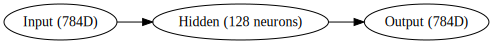

In [36]:
AE_diagram

In [37]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = autoencoder.fit(x_train, x_train, validation_split=.2, epochs=epochs)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 9s 182us/step - loss: 0.1251 - acc: 0.8092 - val_loss: 0.0812 - val_acc: 0.8158
Epoch 2/2
48000/48000 [==============================] - 8s 171us/step - loss: 0.0746 - acc: 0.8151 - val_loss: 0.0717 - val_acc: 0.8160


Embed the digits in a low-dimensional space

In [38]:
encoder = Model(inputs, encoded)

embeddings = encoder.predict(x_test)

embeddings.shape

(10000, 128)

Decode the embeddings

In [39]:
encoded_inputs = Input(shape=(embedding_dims,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_inputs, decoder_layer(encoded_inputs))

decoded_embeddings = decoder.predict(embeddings)

decoded_embeddings.shape

(10000, 784)

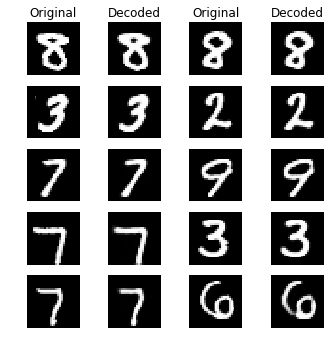

In [40]:
show_decodings(x_test, decoded_embeddings)

## Denoise data

Use an autoencoder to denoise corrupted images

In [41]:
x_train, y_train, x_test, y_test = load_mnist_images()

x_train_corrupted = np.array([corrupt_image(i) for i in x_train]).reshape(-1, 28**2)
x_test_corrupted = np.array([corrupt_image(i) for i in x_test]).reshape(-1, 28**2)
x_train, x_test = x_train.reshape(-1, 28**2), x_test.reshape(-1, 28**2)

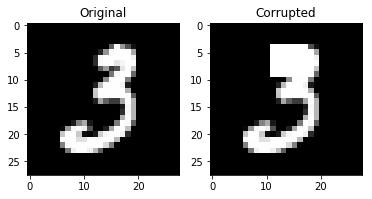

In [42]:
fig, ax = plt.subplots(1, 2)
r = np.random.randint(0, x_train.shape[0])
ax[0].imshow(x_train[r].reshape(28, 28), cmap='Greys_r'); ax[0].set_title('Original')
ax[1].imshow(x_train_corrupted[r].reshape(28, 28), cmap='Greys_r'); ax[1].set_title('Corrupted');

Train the autoencoder to map corrupted data to original data

In [43]:
inputs = Input(shape=(x_train.shape[1],))
hidden = Dense(units=256, activation='relu')(inputs)
encoded = Dense(units=128, activation='linear')(hidden)
hidden = Dense(units=256, activation='relu')(encoded)
decoded = Dense(units=x_train.shape[1], activation='sigmoid')(hidden)

autoencoder = Model(inputs, decoded)

In [44]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = autoencoder.fit(x_train_corrupted, x_train, validation_split=.2, epochs=epochs)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 12s 260us/step - loss: 0.1449 - acc: 0.8051 - val_loss: 0.1153 - val_acc: 0.8111
Epoch 2/2
48000/48000 [==============================] - 12s 243us/step - loss: 0.1099 - acc: 0.8104 - val_loss: 0.1076 - val_acc: 0.8117


Denoise the corrupted test data

In [45]:
denoised = autoencoder.predict(x_test_corrupted)

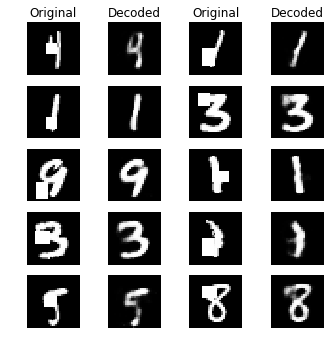

In [46]:
show_decodings(x_test_corrupted, denoised.reshape(-1, 28, 28))

## Autoencoding other data

In [47]:
(_, _), (fashion_mnist_images, _) = fashion_mnist.load_data()

fashion_mnist_images = fashion_mnist_images.reshape(-1, 28**2) / 255

fashion_mnist_autoencoded = autoencoder.predict(fashion_mnist_images)

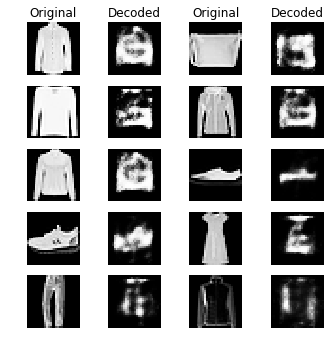

In [48]:
show_decodings(fashion_mnist_images, fashion_mnist_autoencoded)

## Autoencoding Blade Runner

https://www.youtube.com/watch?v=3zTMyR-IE4Q

## Autoencoders for dimensionality reduction

In [49]:
x_train, y_train, x_test, y_test = load_mnist_vectors()

### PCA

Deterministic method to **decompose** data into $n$ **principal components** that most explain the **variance** between examples

In [50]:
pca = PCA(n_components=2)
pca.fit(StandardScaler().fit_transform(x_train).T)
x, y = pca.components_

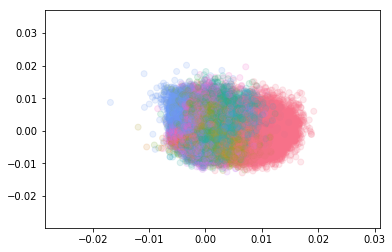

In [51]:
plt.scatter(x, y, c=list(map(lambda x: cmap[x], y_train)), alpha=.15);

### Autoencoder

Or, we could use an autoencoder with 2 units in the encoding layer

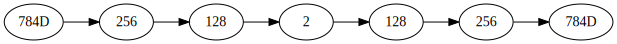

In [52]:
DAE_diagram

In [53]:
inputs = Input(shape=(x_train.shape[1],))
hidden = Dense(units=256, activation='relu')(inputs)
hidden = Dense(units=128, activation='relu')(hidden)

encoded = Dense(units=2, activation='linear')(hidden)

hidden = Dense(units=64, activation='relu')(encoded)
hidden = Dense(units=128, activation='relu')(hidden)
hidden = Dense(units=256, activation='relu')(hidden)
decoded = Dense(units=x_train.shape[1], activation='sigmoid')(hidden)

autoencoder = Model(inputs, decoded)

In [54]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = autoencoder.fit(x_train, x_train, validation_split=.2, epochs=epochs)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 14s 289us/step - loss: 0.2167 - acc: 0.7932 - val_loss: 0.1933 - val_acc: 0.7972
Epoch 2/2
48000/48000 [==============================] - 13s 274us/step - loss: 0.1884 - acc: 0.7963 - val_loss: 0.1846 - val_acc: 0.7974


In [55]:
encoder = Model(inputs, encoded)

embeddings = encoder.predict(x_train)

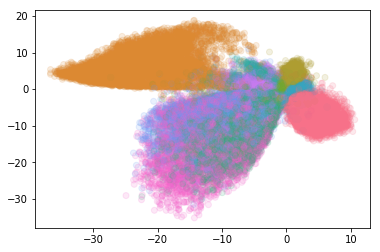

In [56]:
plt.scatter(embeddings[:,0], embeddings[:,1], c=list(map(lambda x: cmap[x], y_train)), alpha=.15);

### Convolutional autoencoder

We should really use a convnet if we're dealing with image data

In [57]:
x_train, y_train, x_test, y_test = load_mnist_images()

In [58]:
inputs = Input(shape=x_train.shape[1:])
conv = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
pooling = MaxPool2D(pool_size=(2, 2), padding='same')(conv)
flatten = Flatten()(pooling)
hidden = Dense(256, activation='relu')(flatten)
hidden = Dense(128, activation='relu')(hidden)

encoded = Dense(2, activation='linear')(hidden)

hidden = Dense(128, activation='relu')(hidden)
hidden = Dense(256, activation='relu')(encoded)
reshape = Dense(1568, activation='relu')(hidden)
reshape = Reshape((14, 14, 8))(reshape)
conv = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(reshape)
upsample = UpSampling2D(size=(2, 2))(conv)
decoded = Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(upsample)

autoencoder = Model(inputs, decoded)

In [59]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = autoencoder.fit(x_train, x_train, validation_split=.2, epochs=epochs)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 59s 1ms/step - loss: 0.2168 - acc: 0.7927 - val_loss: 0.1965 - val_acc: 0.7938
Epoch 2/2
48000/48000 [==============================] - 54s 1ms/step - loss: 0.1921 - acc: 0.7943 - val_loss: 0.1895 - val_acc: 0.7952


In [60]:
encoder = Model(inputs, encoded)

embeddings = encoder.predict(x_train)

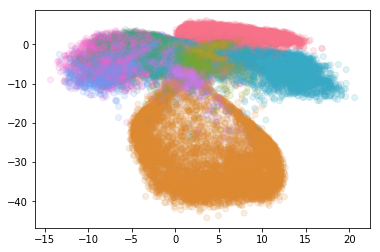

In [61]:
plt.scatter(embeddings[:,0], embeddings[:,1], c=list(map(lambda x: cmap[x], y_train)), alpha=.15);

# Take home messages

* Neural networks are not just one thing

* Autoencoders are a type of neural network with a wide range of applications

* I am using autoencoders for unsupervised feature learning